<a href="https://colab.research.google.com/github/yongtaoliu/MHP_GB_by_ResHedNet/blob/main/ResHeDNet_Ensemble_MHP_GBs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ResHedNet for MHP Grain Boundary**

Sep, 2022

*   Workflow by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
*   Training realized by [AtomAi](https://atomai.readthedocs.io/en/latest/) by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)






# **Install, Import, and Download**


*   Install and import required packages
*   Download train, test, and target PFM data set



In [1]:
!pip install imgaug==0.2.6
!pip install atomai
!pip install -U gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 5.0 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=02d48c1da16831777ce3cca42097b627ee0936e180dcb7b145ed7227b36f0ff7
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 5.1 MB/s 
     |████████████████████████████████| 193 kB 7.4 MB/s 
     |████████████████████████████████| 361 kB 69.7 MB/s 
     |████████████████████████████████| 865 kB 64.3 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl si

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from atomai.utils import extract_patches_ 
import atomai as aoi

import torch
import torch.nn as nn
import torch.nn.functional as F
import os

from scipy.ndimage import gaussian_filter

# **Prepare train data**


*   Extract subimages and corresponding labeled wall maps from images
*   Totally xxxx subimages and corresponding xxxx wall maps were prepared for training
*   All subimages and wall maps were spilted into 80% and 20% as train data and validation data, respectively.



Define a function to extract sub_ images and _labeled walls

In [3]:
#title Define function: extract_subimage
def extract_subimage2 (x_train, y_train):
  #set patch number and patch size
  numpatches = 2000
  patchsize = 250

  #read and normalize x_train
  img = np.load(x_train)
  img = (img - img.min()) / img.ptp()
  noise = np.random.randn(256, 256)
  img = (img - img.min()) / img.ptp()

  #read and normalize y_train
  lab = plt.imread(y_train)
  if len(lab.shape) == 3:
    lab = lab[:,:,1]
  else:
    lab = lab
  lab = (lab - lab.min()) / lab.ptp()
  _, lab = cv2.threshold(lab, 0.7, 1, cv2.THRESH_BINARY)
  idx_ = np.asarray(np.where(lab==1))
  idx = idx_/(652/256)
  idx = idx.astype(int)
  lab = np.zeros((256,256))
  lab[idx[0,],idx[1,]]=1

  #generate training batch
  imgs, labs = extract_patches_(img, lab, patch_size=patchsize, num_patches=numpatches, random_state=42)

  #return subimage and label sets
  return imgs, labs

download and unzip raw data

In [4]:
!gdown https://drive.google.com/uc?id=1r8aZtsIVTinYySycEH8d2ewQmd-Vq4fb

Downloading...
From: https://drive.google.com/uc?id=1r8aZtsIVTinYySycEH8d2ewQmd-Vq4fb
To: /content/20220811.zip
100% 24.6M/24.6M [00:00<00:00, 147MB/s] 


In [5]:
! unzip -q 20220811.zip

load raw data

In [11]:
os.chdir("/content/20200811")

xtrain_load = ['topo_2um_01.npy',
               'topo_2um_02.npy']

ytrain_load = ['defl_2um_01_label1.tif',
               'defl_2um_02_label1.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,250,250])
ytrain = np.empty([0,250,250])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage2(x_train = i, y_train = j)
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

print(xtrain.shape, ytrain.shape)

(98, 250, 250) (98, 250, 250)


Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)

In [12]:
#shuffle images
arr = np.arange(len(xtrain))

imgs_ = np.copy(xtrain)
labs_ = np.copy(ytrain)

for i in range (len(xtrain)):
  imgs_[i] = xtrain [arr[i]]
  labs_[i] = ytrain [arr[i]]

In [13]:
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = imgs_ [arr[i]]
  labs[i] = labs_ [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Show train and validation images

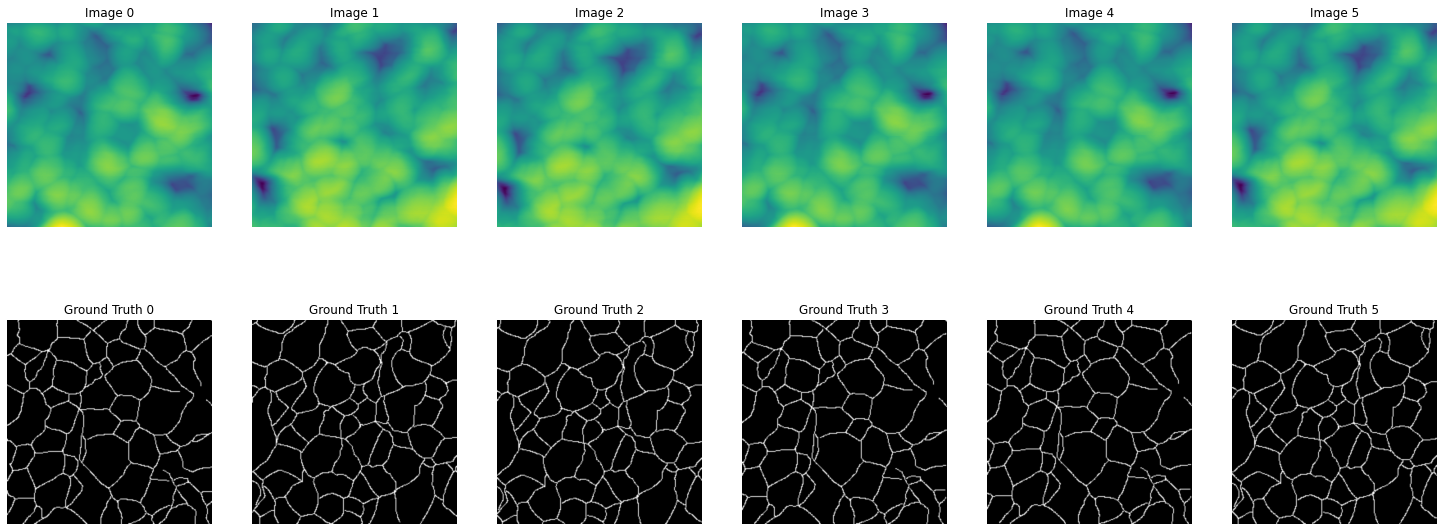

In [14]:
# show training images
n = 5

n = n + 2
fig = plt.figure(figsize=(30, 10))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_train[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

In [ ]:
# show validation images
n = 5

n = n + 2
fig = plt.figure(figsize=(30, 10))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_val[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1))
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

## **Define and train the model**



In [ ]:
etrainer = aoi.trainers.EnsembleTrainer("ResHedNet", nb_classes=1)
etrainer.compile_ensemble_trainer(
    training_cycles=2000, loss='focal', batch_size=10, compute_accuracy=True, swa=True)

In [ ]:
augment_fn = aoi.transforms.seg_augmentor(
    nb_classes=1, contrast=True, blur=True, rotation=True)

Training ensemble models (strategy = 'from_scratch')

Ensemble model 1
Epoch 1/2000 ... Training loss: 0.1091 ... Test loss: 0.08 ... Train Accuracy: 0.2763 ... Test Accuracy: 0.4628 ... GPU memory usage: 8746/15109
Epoch 100/2000 ... Training loss: 0.0531 ... Test loss: 0.0632 ... Train Accuracy: 0.5407 ... Test Accuracy: 0.4539 ... GPU memory usage: 8746/15109
Epoch 200/2000 ... Training loss: 0.0322 ... Test loss: 0.0325 ... Train Accuracy: 0.6134 ... Test Accuracy: 0.5936 ... GPU memory usage: 8746/15109
Epoch 300/2000 ... Training loss: 0.0196 ... Test loss: 0.0294 ... Train Accuracy: 0.6434 ... Test Accuracy: 0.5807 ... GPU memory usage: 8746/15109
Epoch 400/2000 ... Training loss: 0.0118 ... Test loss: 0.0125 ... Train Accuracy: 0.6879 ... Test Accuracy: 0.6758 ... GPU memory usage: 8746/15109
Epoch 500/2000 ... Training loss: 0.0078 ... Test loss: 0.0076 ... Train Accuracy: 0.716 ... Test Accuracy: 0.709 ... GPU memory usage: 8746/15109
Epoch 600/2000 ... Training loss: 0.0054 

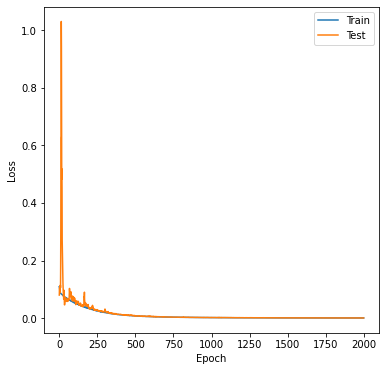


Ensemble model 2
Epoch 1/2000 ... Training loss: 0.116 ... Test loss: 0.0851 ... Train Accuracy: 0.3042 ... Test Accuracy: 0.4127 ... GPU memory usage: 8826/15109
Epoch 100/2000 ... Training loss: 0.0583 ... Test loss: 0.0657 ... Train Accuracy: 0.5029 ... Test Accuracy: 0.4788 ... GPU memory usage: 8828/15109
Epoch 200/2000 ... Training loss: 0.0352 ... Test loss: 0.0265 ... Train Accuracy: 0.56 ... Test Accuracy: 0.5513 ... GPU memory usage: 8828/15109
Epoch 300/2000 ... Training loss: 0.021 ... Test loss: 0.0206 ... Train Accuracy: 0.5995 ... Test Accuracy: 0.6039 ... GPU memory usage: 8828/15109
Epoch 400/2000 ... Training loss: 0.0129 ... Test loss: 0.0141 ... Train Accuracy: 0.6344 ... Test Accuracy: 0.6103 ... GPU memory usage: 8828/15109
Epoch 500/2000 ... Training loss: 0.0091 ... Test loss: 0.0133 ... Train Accuracy: 0.6256 ... Test Accuracy: 0.5949 ... GPU memory usage: 8828/15109
Epoch 600/2000 ... Training loss: 0.0063 ... Test loss: 0.0077 ... Train Accuracy: 0.6526 ... 

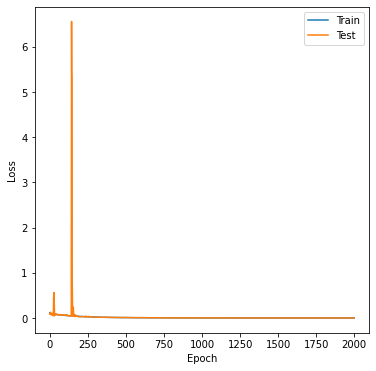


Ensemble model 3
Epoch 1/2000 ... Training loss: 0.1287 ... Test loss: 0.0907 ... Train Accuracy: 0.2918 ... Test Accuracy: 0.0775 ... GPU memory usage: 8834/15109
Epoch 100/2000 ... Training loss: 0.0538 ... Test loss: 0.0564 ... Train Accuracy: 0.5352 ... Test Accuracy: 0.495 ... GPU memory usage: 8834/15109
Epoch 200/2000 ... Training loss: 0.0332 ... Test loss: 0.0455 ... Train Accuracy: 0.5959 ... Test Accuracy: 0.5461 ... GPU memory usage: 8834/15109
Epoch 300/2000 ... Training loss: 0.0213 ... Test loss: 0.0201 ... Train Accuracy: 0.6091 ... Test Accuracy: 0.6218 ... GPU memory usage: 8834/15109
Epoch 400/2000 ... Training loss: 0.0129 ... Test loss: 0.0133 ... Train Accuracy: 0.6565 ... Test Accuracy: 0.6238 ... GPU memory usage: 8834/15109
Epoch 500/2000 ... Training loss: 0.0089 ... Test loss: 0.0099 ... Train Accuracy: 0.6575 ... Test Accuracy: 0.6439 ... GPU memory usage: 8834/15109
Epoch 600/2000 ... Training loss: 0.006 ... Test loss: 0.0066 ... Train Accuracy: 0.6891 ..

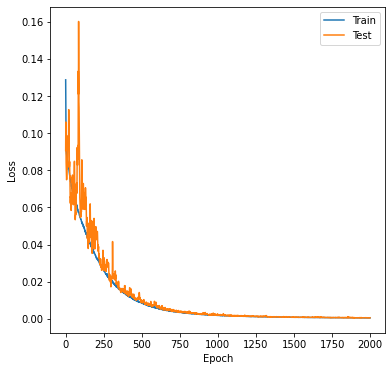


Ensemble model 4
Epoch 1/2000 ... Training loss: 0.0951 ... Test loss: 0.0947 ... Train Accuracy: 0.279 ... Test Accuracy: 0.039 ... GPU memory usage: 8878/15109
Epoch 100/2000 ... Training loss: 0.0566 ... Test loss: 0.0547 ... Train Accuracy: 0.553 ... Test Accuracy: 0.5395 ... GPU memory usage: 8880/15109
Epoch 200/2000 ... Training loss: 0.0351 ... Test loss: 0.0349 ... Train Accuracy: 0.6129 ... Test Accuracy: 0.6051 ... GPU memory usage: 8880/15109
Epoch 300/2000 ... Training loss: 0.0203 ... Test loss: 0.0209 ... Train Accuracy: 0.66 ... Test Accuracy: 0.6396 ... GPU memory usage: 8880/15109
Epoch 400/2000 ... Training loss: 0.0114 ... Test loss: 0.0128 ... Train Accuracy: 0.7138 ... Test Accuracy: 0.661 ... GPU memory usage: 8880/15109
Epoch 500/2000 ... Training loss: 0.0072 ... Test loss: 0.0074 ... Train Accuracy: 0.7407 ... Test Accuracy: 0.7187 ... GPU memory usage: 8880/15109
Epoch 600/2000 ... Training loss: 0.0048 ... Test loss: 0.0056 ... Train Accuracy: 0.7665 ... Te

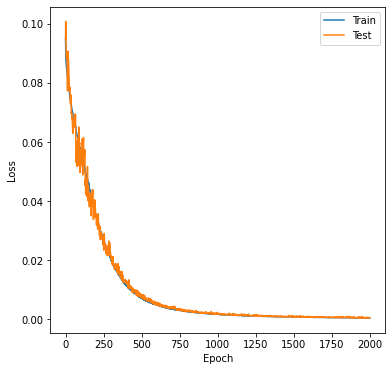


Ensemble model 5
Epoch 1/2000 ... Training loss: 0.1367 ... Test loss: 0.1153 ... Train Accuracy: 0.2552 ... Test Accuracy: 0.0365 ... GPU memory usage: 8962/15109
Epoch 100/2000 ... Training loss: 0.0459 ... Test loss: 0.0385 ... Train Accuracy: 0.5483 ... Test Accuracy: 0.4907 ... GPU memory usage: 8962/15109
Epoch 200/2000 ... Training loss: 0.025 ... Test loss: 0.0314 ... Train Accuracy: 0.6105 ... Test Accuracy: 0.5689 ... GPU memory usage: 8962/15109
Epoch 300/2000 ... Training loss: 0.0155 ... Test loss: 0.016 ... Train Accuracy: 0.6125 ... Test Accuracy: 0.6089 ... GPU memory usage: 8962/15109
Epoch 400/2000 ... Training loss: 0.0097 ... Test loss: 0.0109 ... Train Accuracy: 0.6465 ... Test Accuracy: 0.5834 ... GPU memory usage: 8962/15109
Epoch 500/2000 ... Training loss: 0.007 ... Test loss: 0.0104 ... Train Accuracy: 0.6505 ... Test Accuracy: 0.5971 ... GPU memory usage: 8962/15109
Epoch 600/2000 ... Training loss: 0.0048 ... Test loss: 0.0063 ... Train Accuracy: 0.6787 ...

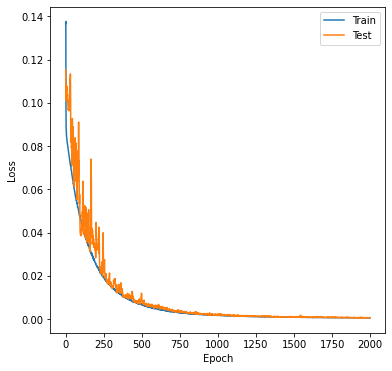


Ensemble model 6
Epoch 1/2000 ... Training loss: 0.1478 ... Test loss: 0.1078 ... Train Accuracy: 0.2875 ... Test Accuracy: 0.0351 ... GPU memory usage: 8950/15109
Epoch 100/2000 ... Training loss: 0.0449 ... Test loss: 0.0427 ... Train Accuracy: 0.5551 ... Test Accuracy: 0.5365 ... GPU memory usage: 8950/15109
Epoch 200/2000 ... Training loss: 0.0248 ... Test loss: 0.0305 ... Train Accuracy: 0.6036 ... Test Accuracy: 0.5796 ... GPU memory usage: 8950/15109
Epoch 300/2000 ... Training loss: 0.0154 ... Test loss: 0.0155 ... Train Accuracy: 0.6105 ... Test Accuracy: 0.6093 ... GPU memory usage: 8950/15109
Epoch 400/2000 ... Training loss: 0.0095 ... Test loss: 0.0109 ... Train Accuracy: 0.6524 ... Test Accuracy: 0.6237 ... GPU memory usage: 8950/15109
Epoch 500/2000 ... Training loss: 0.0075 ... Test loss: 0.0081 ... Train Accuracy: 0.6168 ... Test Accuracy: 0.6161 ... GPU memory usage: 8950/15109
Epoch 600/2000 ... Training loss: 0.0051 ... Test loss: 0.0065 ... Train Accuracy: 0.6564 

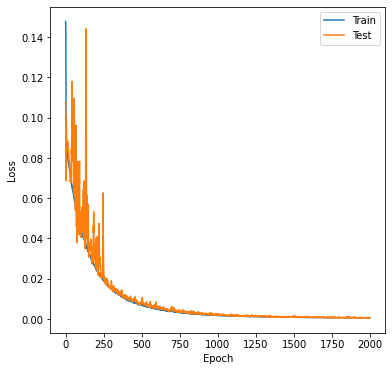


Ensemble model 7
Epoch 1/2000 ... Training loss: 0.119 ... Test loss: 0.0933 ... Train Accuracy: 0.2125 ... Test Accuracy: 0.0328 ... GPU memory usage: 8996/15109
Epoch 100/2000 ... Training loss: 0.0489 ... Test loss: 0.0648 ... Train Accuracy: 0.5569 ... Test Accuracy: 0.466 ... GPU memory usage: 8996/15109
Epoch 200/2000 ... Training loss: 0.0282 ... Test loss: 0.029 ... Train Accuracy: 0.6108 ... Test Accuracy: 0.6106 ... GPU memory usage: 8996/15109
Epoch 300/2000 ... Training loss: 0.0175 ... Test loss: 0.0211 ... Train Accuracy: 0.6219 ... Test Accuracy: 0.6138 ... GPU memory usage: 8996/15109
Epoch 400/2000 ... Training loss: 0.0106 ... Test loss: 0.0114 ... Train Accuracy: 0.658 ... Test Accuracy: 0.6381 ... GPU memory usage: 8996/15109
Epoch 500/2000 ... Training loss: 0.0072 ... Test loss: 0.0074 ... Train Accuracy: 0.6846 ... Test Accuracy: 0.6621 ... GPU memory usage: 8996/15109
Epoch 600/2000 ... Training loss: 0.005 ... Test loss: 0.0065 ... Train Accuracy: 0.7121 ... T

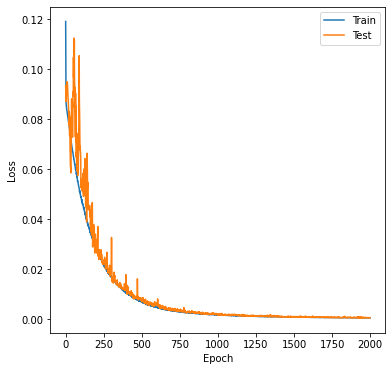


Ensemble model 8
Epoch 1/2000 ... Training loss: 0.117 ... Test loss: 0.0854 ... Train Accuracy: 0.3347 ... Test Accuracy: 0.3848 ... GPU memory usage: 9002/15109
Epoch 100/2000 ... Training loss: 0.054 ... Test loss: 0.0636 ... Train Accuracy: 0.5344 ... Test Accuracy: 0.4346 ... GPU memory usage: 9002/15109
Epoch 200/2000 ... Training loss: 0.033 ... Test loss: 0.034 ... Train Accuracy: 0.6035 ... Test Accuracy: 0.5909 ... GPU memory usage: 9002/15109
Epoch 300/2000 ... Training loss: 0.021 ... Test loss: 0.0235 ... Train Accuracy: 0.6168 ... Test Accuracy: 0.6081 ... GPU memory usage: 9002/15109
Epoch 400/2000 ... Training loss: 0.0126 ... Test loss: 0.0132 ... Train Accuracy: 0.6634 ... Test Accuracy: 0.6206 ... GPU memory usage: 9002/15109
Epoch 500/2000 ... Training loss: 0.0086 ... Test loss: 0.009 ... Train Accuracy: 0.6731 ... Test Accuracy: 0.6588 ... GPU memory usage: 9002/15109
Epoch 600/2000 ... Training loss: 0.0057 ... Test loss: 0.0065 ... Train Accuracy: 0.7103 ... Te

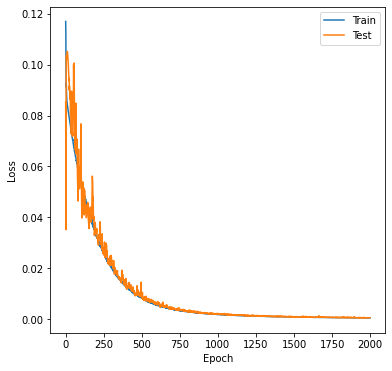


Ensemble model 9
Epoch 1/2000 ... Training loss: 0.0939 ... Test loss: 0.0784 ... Train Accuracy: 0.2708 ... Test Accuracy: 0.467 ... GPU memory usage: 9084/15109
Epoch 100/2000 ... Training loss: 0.0563 ... Test loss: 0.0666 ... Train Accuracy: 0.5423 ... Test Accuracy: 0.5075 ... GPU memory usage: 9086/15109
Epoch 200/2000 ... Training loss: 0.0353 ... Test loss: 0.0408 ... Train Accuracy: 0.6099 ... Test Accuracy: 0.5779 ... GPU memory usage: 9086/15109
Epoch 300/2000 ... Training loss: 0.021 ... Test loss: 0.0223 ... Train Accuracy: 0.6492 ... Test Accuracy: 0.6413 ... GPU memory usage: 9086/15109
Epoch 400/2000 ... Training loss: 0.0121 ... Test loss: 0.0125 ... Train Accuracy: 0.6993 ... Test Accuracy: 0.6759 ... GPU memory usage: 9086/15109
Epoch 500/2000 ... Training loss: 0.0075 ... Test loss: 0.0079 ... Train Accuracy: 0.7399 ... Test Accuracy: 0.716 ... GPU memory usage: 9086/15109
Epoch 600/2000 ... Training loss: 0.005 ... Test loss: 0.0055 ... Train Accuracy: 0.7611 ... 

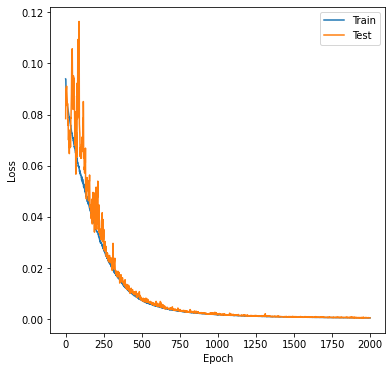


Ensemble model 10
Epoch 1/2000 ... Training loss: 0.1359 ... Test loss: 0.114 ... Train Accuracy: 0.2549 ... Test Accuracy: 0.0336 ... GPU memory usage: 9074/15109
Epoch 100/2000 ... Training loss: 0.0487 ... Test loss: 0.0511 ... Train Accuracy: 0.5495 ... Test Accuracy: 0.5141 ... GPU memory usage: 9074/15109
Epoch 200/2000 ... Training loss: 0.0285 ... Test loss: 0.0283 ... Train Accuracy: 0.6039 ... Test Accuracy: 0.5996 ... GPU memory usage: 9074/15109
Epoch 300/2000 ... Training loss: 0.018 ... Test loss: 0.0183 ... Train Accuracy: 0.6157 ... Test Accuracy: 0.6159 ... GPU memory usage: 9074/15109
Epoch 400/2000 ... Training loss: 0.0111 ... Test loss: 0.0145 ... Train Accuracy: 0.6531 ... Test Accuracy: 0.6118 ... GPU memory usage: 9074/15109
Epoch 500/2000 ... Training loss: 0.0082 ... Test loss: 0.0089 ... Train Accuracy: 0.6393 ... Test Accuracy: 0.6357 ... GPU memory usage: 9074/15109
Epoch 600/2000 ... Training loss: 0.0056 ... Test loss: 0.0066 ... Train Accuracy: 0.6665 .

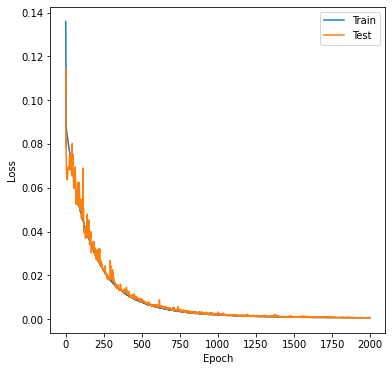

In [ ]:
smodel, ensemble = etrainer.train_ensemble_from_scratch(
    x_train, y_train, x_val, y_val, n_models=10, augment_fn=augment_fn) 
    # filename = "MHP_Grainboundry")  #save weight by offering a filename 

Make precition on validation images and compare with ground truth

In [ ]:
t = np.load("/content/topo_2um_03.npy")
t = (t-t.min())/t.ptp()

predictor = aoi.predictors.EnsemblePredictor(smodel, ensemble, nb_classes=1)
pred_mean, pred_var = predictor.predict(t)

pred_mean.shape, pred_var.shape

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(t)
ax1.axis('off')
ax2.imshow(pred_mean[0,:,:,0])
ax2.axis('off')
ax3.imshow(pred_var[0,:,:,0])
ax3.axis('off')

Batch 1/1

(-0.5, 255.5, 255.5, -0.5)

Batch 1/1

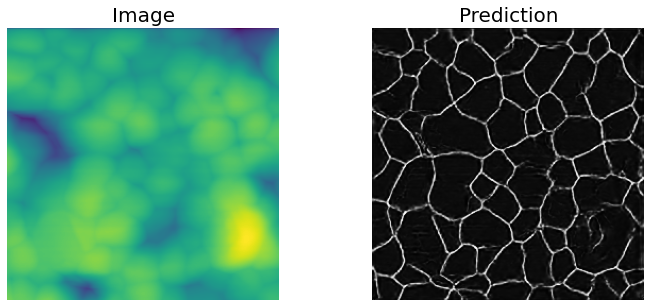

Batch 1/1

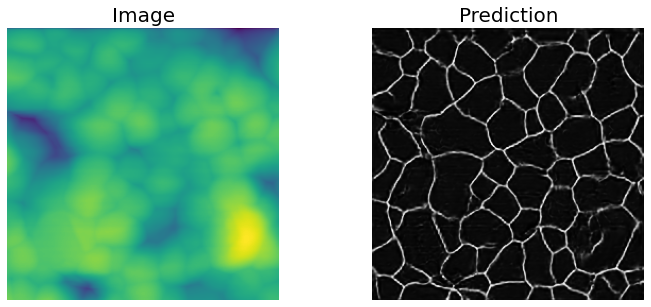

Batch 1/1

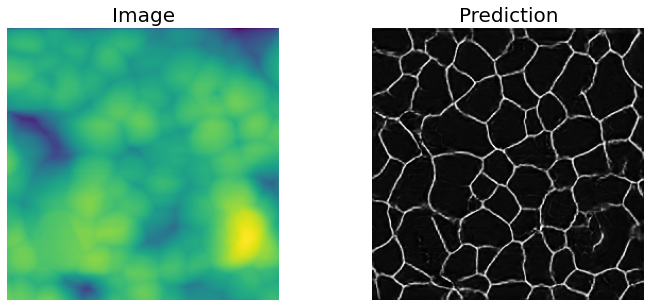

Batch 1/1

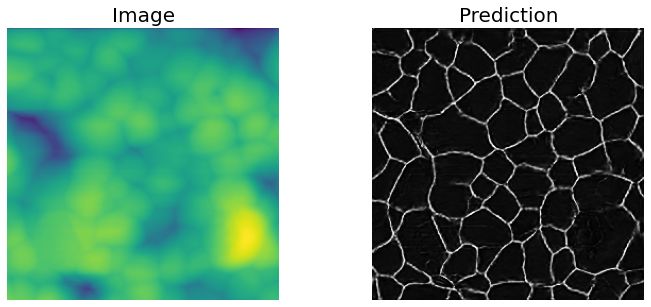

Batch 1/1

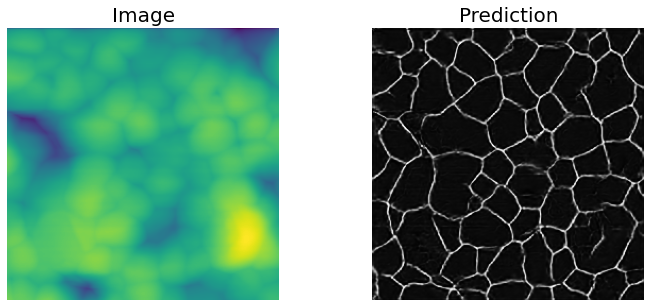

Batch 1/1

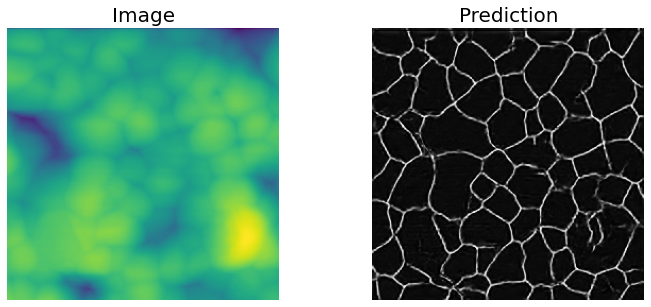

Batch 1/1

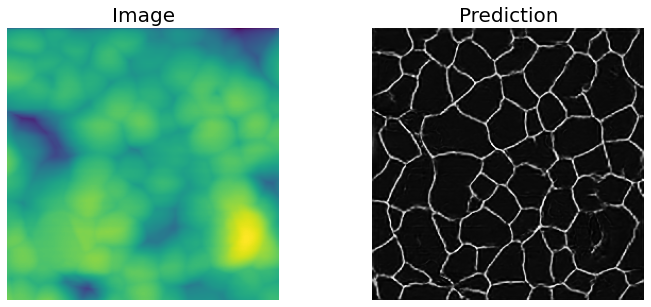

Batch 1/1

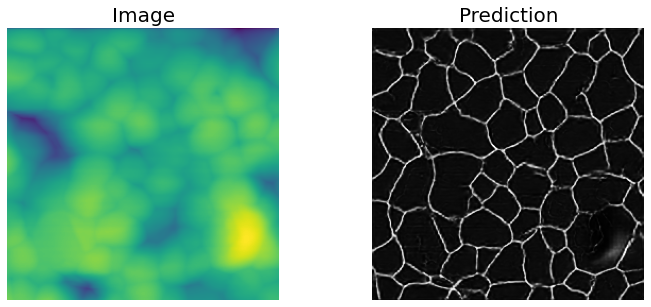

Batch 1/1

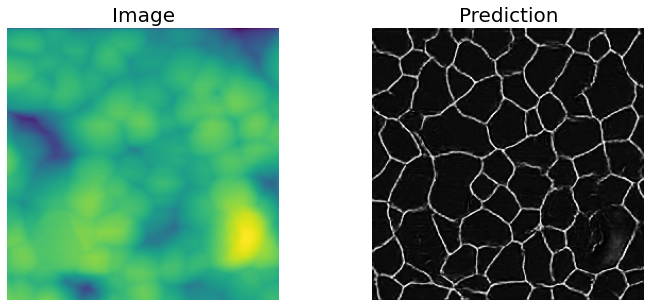

Batch 1/1

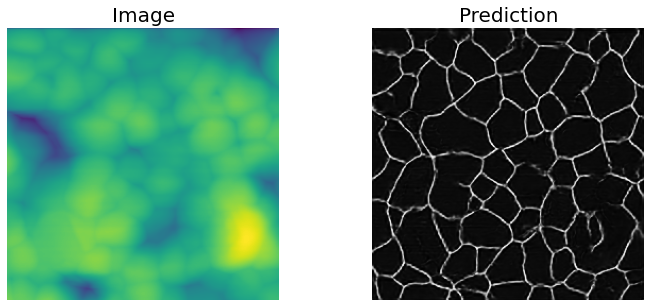

In [ ]:
for m in ensemble.values():
    smodel.load_state_dict(m)
    p = aoi.predictors.SegPredictor(smodel, use_gpu=True)
    pred = p.predict(t)
    _,(ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    ax0.imshow(t)
    ax0.axis ('off')
    ax0.set_title('Image', fontsize = 20)
    ax1.imshow(pred.squeeze(), cmap = 'gray')
    ax1.axis('off')
    ax1.set_title('Prediction', fontsize = 20)
    plt.show()

In [ ]:
t = np.load("/content/topo_2um_04.npy")
t = (t-t.min())/t.ptp()

predictor = aoi.predictors.EnsemblePredictor(smodel, ensemble, nb_classes=1)
pred_mean, pred_var = predictor.predict(t)

pred_mean.shape, pred_var.shape

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(t)
ax1.axis('off')
ax2.imshow(pred_mean[0,:,:,0])
ax2.axis('off')
ax3.imshow(pred_var[0,:,:,0])
ax3.axis('off')

In [ ]:
t = np.load("/content/topo_2um_05.npy")
t = (t-t.min())/t.ptp()

predictor = aoi.predictors.EnsemblePredictor(smodel, ensemble, nb_classes=1)
pred_mean, pred_var = predictor.predict(t)

pred_mean.shape, pred_var.shape

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(t)
ax1.axis('off')
ax2.imshow(pred_mean[0,:,:,0])
ax2.axis('off')
ax3.imshow(pred_var[0,:,:,0])
ax3.axis('off')